<a href="https://colab.research.google.com/github/nidhaloff/MLP_Pytorch/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [465]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# run keras model on google GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:

X_train = np.arange(1, 1001).reshape(-1, 1)
X_test = np.arange(1000, 1500).reshape(-1, 1)
y_train = np.array([2 * x[0] + np.random.rand() for x in X_train]).reshape(-1, 1)
y_test = np.array([2 * x[0] + np.random.rand() for x in X_test]).reshape(-1, 1)

# print(X_train[:5])
# print(y_train[:5])
# print(X_test[:5])
# print(y_test[:5])
# scaler = StandardScaler()
# print(np.max(X_train), np.max(X_test))
# print(y_train[:10])
# X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
# print(np.max(X_train), np.max(X_test))

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(np.array(y_train)).float()
y_test = torch.from_numpy(np.array(y_test)).float()


In [0]:
trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset = torch.utils.data.TensorDataset(X_test, y_test)


In [0]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [0]:
class Model(nn.Module):
    def __init__(self, n_features, n_hidden, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        # self.fc2 = nn.Linear(n_hidden, n_out)
        # self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        # x = self.relu(x)
        # x = self.fc2(x)
        return x

In [470]:
model = Model(X.shape[1],1, 1)
print(model)

Model(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)


In [0]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)

def train(model, optimizer, loss_fn):
    def train_step(x, y):
        model.train()
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step


In [0]:
def fit(epochs=100):
    train_func = train(model, optimizer, criterion)
    count, total = 0, 0
    loss_list, accuracy_list, iters = [], [], []
    for e in range(epochs):
        for X, y in train_loader:
            loss = train_func(X, y)
            count += 1
            total += len(y)
            if count % 50 == 0:
                print("loss= ", loss)
                loss_list.append(loss)
                iters.append(total)

            if count % 100 == 0:
                model.eval()
                out = model(X)
                out = out.detach().numpy()
                y = y.detach().numpy()
                accuracy = r2_score(y, out)
                print("accuracy = ", accuracy)
                accuracy_list.append(accuracy)
    
    return iters, loss_list, accuracy_list


In [473]:
iters, loss_list, accuracy_list = fit(epochs=20)
print(loss_list)
print("acc list: ", accuracy_list)

loss=  4999.20263671875
loss=  14.009926795959473
accuracy =  0.9999756307107588
loss=  0.11514446139335632
loss=  0.13048475980758667
accuracy =  0.9999996334333044
loss=  0.10948947817087173
loss=  0.1115807294845581
accuracy =  0.9999996079448497
[4999.20263671875, 14.009926795959473, 0.11514446139335632, 0.13048475980758667, 0.10948947817087173, 0.1115807294845581]
acc list:  [0.9999756307107588, 0.9999996334333044, 0.9999996079448497]


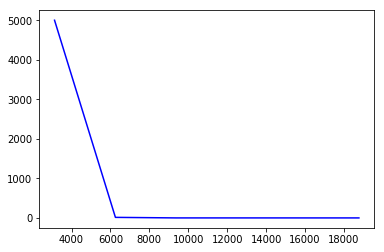

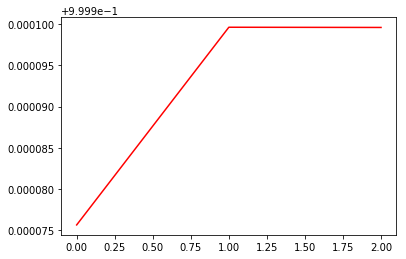

In [474]:
plt.plot(iters, loss_list, color="b")
plt.show()
plt.plot(np.arange(0, len(accuracy_list)), accuracy_list, color="r")
plt.show()

In [0]:
def test():
    model.eval()
    loss_list, accs = [], []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            pred = model(x_test)
            # print(pred.shape, y_test.shape)
            loss = criterion(pred, y_test)
            loss_list.append(loss.item())
            acc = r2_score(y_test.numpy(), pred.numpy())
            print("r2_score: ", acc)
            acc1 = 1 - (loss.item() / (torch.var(y_test)))
            print("own function: ", acc1.item())
            accs.append(acc)

    return loss_list, accs

In [476]:
losses, accs = test()
print("losses: ", losses)
print("="*50)
print("accuracy => ", sum(accs)/len(accs))
print(accs)

r2_score:  0.9999063453412198
own function:  0.9999077916145325
r2_score:  0.9998920713423389
own function:  0.9998937845230103
r2_score:  0.9998782885848229
own function:  0.9998801946640015
r2_score:  0.9998760278134515
own function:  0.9998779892921448
r2_score:  0.9998887488284989
own function:  0.9998905062675476
r2_score:  0.9998575261854227
own function:  0.9998597502708435
r2_score:  0.9998352553305344
own function:  0.9998378157615662
r2_score:  0.9997210001287214
own function:  0.9997263550758362
losses:  [0.12791192531585693, 0.14752505719661713, 0.1660080850124359, 0.16892458498477936, 0.1520095318555832, 0.1949945092201233, 0.2257261872291565, 0.2508370876312256]
accuracy =>  0.9998569079443763
[0.9999063453412198, 0.9998920713423389, 0.9998782885848229, 0.9998760278134515, 0.9998887488284989, 0.9998575261854227, 0.9998352553305344, 0.9997210001287214]


In [477]:
preds = model(X_test[0])
print(preds)
print("="*40)
print(y_test[0])

tensor([2000.3136], grad_fn=<AddBackward0>)
tensor([2000.6338])
